In [1]:
from SOH_func_scaler import *
import matplotlib.pyplot as pl
from keras import models, layers
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime
import os

%load_ext tensorboard

In [2]:
VERSION = 'LSTM_Comparison_Parallel' # 띄어쓰기 없이 어떤 모델인지 버전을 써주세요

FILE_00 = 'data_csv/CYCLE_CSV_data00.csv'
FILE_01 = 'data_csv/CYCLE_CSV_data01.csv'
FILE_02 = 'data_csv/CYCLE_CSV_data02.csv'
FILE_03 = 'data_csv/CYCLE_CSV_data03.csv'
FILE_04 = 'data_csv/CYCLE_CSV_data04.csv'
FILE_05 = 'data_csv/CYCLE_CSV_data05.csv'
FILE_06 = 'data_csv/CYCLE_CSV_data06.csv'

In [3]:
drop_labels_x = ['인덱스', '사이클_번호', '누적_용량(Ah)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
# 예측에 사용하지 않을 파라미터 목록

param = {'seq_len' : 30, 'num_units' : 64, 'num_filters' : 64, 'window' : 3, 'dropout': 0.1, 'num_epochs' : 2000, 'num_dense': 16}
# 모델 규격 지정 하이퍼파라미터

log_dir = f"logs/{VERSION}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M") + f'-{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
file_path = f'Checkpoints\{VERSION}\SOH_Checkpoint\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ.h5'
hist_freq = 250
# 텐서보드 설정(logs 폴더에 모델 학습 기록 저장)

save_path = f'outputs\{VERSION}\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
try:
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except OSError:
    print('Error Creating Directory...')
# 출력 저장 폴더 생성

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data00.csv => (475, 4)


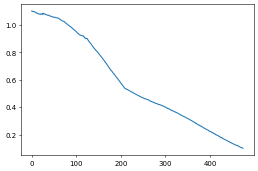

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data02.csv => (515, 4)


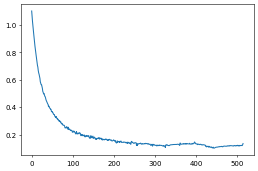

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data05.csv => (515, 4)


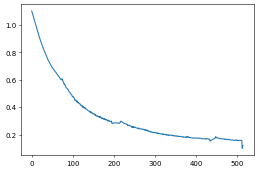

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data04.csv => (515, 4)


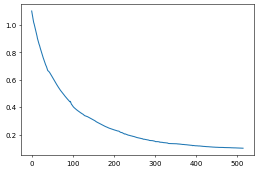

In [4]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)
# data01, data_cap01 = get_data(FILE_01, drop_labels_x, drop_labels_y)
data02, data_cap02 = get_data(FILE_02, drop_labels_x, drop_labels_y)
data04, data_cap04 = get_data(FILE_05, drop_labels_x, drop_labels_y)
data_test, data_cap_test = get_data(FILE_04, drop_labels_x, drop_labels_y)
# 쓸 데이터만 뽑아서 저장(입력 데이터, 정답 데이터)

In [5]:
x_train00 = seq_gen_x(data00, param['seq_len'])
y_train00 = seq_gen_y(data_cap00, param['seq_len'])
# x_train01 = seq_gen_x(data01, param['seq_len'])
# y_train01 = seq_gen_y(data_cap01, param['seq_len'])
x_train02 = seq_gen_x(data02, param['seq_len'])
y_train02 = seq_gen_y(data_cap02, param['seq_len'])
x_train04 = seq_gen_x(data04, param['seq_len'])
y_train04 = seq_gen_y(data_cap04, param['seq_len'])
x_test = seq_gen_x(data_test, param['seq_len'])
y_test = seq_gen_y(data_cap_test, param['seq_len'])
print(x_train00.shape)
print(y_train00.shape)
# print(x_train00[0:5, :, 1])
# print(y_train00[:4])
# 시퀀스 단위로 쪼개기

(445, 30, 4)
(445, 1, 1)


In [6]:
inputs = layers.Input(shape=(param['seq_len'], x_train00.shape[-1]), name = 'Inputs')
x1 = layers.LSTM(param['num_units'], return_sequences = True, name = 'LSTM_sequence0')(inputs)
# CNN과 LSTM 층 출력을 병렬(axis = -1)로 이어 붙히는 concatenate 층
x = layers.LSTM(16, name = 'LSTM_concatenate')(x1)
x = layers.Dropout(param['dropout'], name = 'Dropout')(x)
outputs = layers.Dense(1, name = 'Outputs')(x)
model = models.Model(inputs = inputs, outputs = outputs, name = 'LSTM_PARALLEL')
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()
# 모델 생성

Model: "LSTM_PARALLEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputs (InputLayer)         [(None, 30, 4)]           0         
                                                                 
 LSTM_sequence0 (LSTM)       (None, 30, 64)            17664     
                                                                 
 LSTM_concatenate (LSTM)     (None, 16)                5184      
                                                                 
 Dropout (Dropout)           (None, 16)                0         
                                                                 
 Outputs (Dense)             (None, 1)                 17        
                                                                 
Total params: 22,865
Trainable params: 22,865
Non-trainable params: 0
_________________________________________________________________


In [7]:
BATCH_SIZE = 128
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)
# callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
#                  TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
# fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train02, y_train02, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train04, y_train04, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)

Epoch 1/2000
12/12 - 7s - loss: 0.0764 - val_loss: 0.0047 - 7s/epoch - 601ms/step
Epoch 2/2000
12/12 - 0s - loss: 0.0213 - val_loss: 0.0020 - 202ms/epoch - 17ms/step
Epoch 3/2000
12/12 - 0s - loss: 0.0095 - val_loss: 2.8666e-06 - 131ms/epoch - 11ms/step
Epoch 4/2000
12/12 - 0s - loss: 0.0061 - val_loss: 1.5369e-05 - 110ms/epoch - 9ms/step
Epoch 5/2000
12/12 - 0s - loss: 0.0039 - val_loss: 3.9414e-04 - 104ms/epoch - 9ms/step
Epoch 6/2000
12/12 - 0s - loss: 0.0061 - val_loss: 3.1418e-04 - 99ms/epoch - 8ms/step
Epoch 7/2000
12/12 - 0s - loss: 0.0043 - val_loss: 2.3833e-04 - 111ms/epoch - 9ms/step
Epoch 8/2000
12/12 - 0s - loss: 0.0040 - val_loss: 4.2179e-06 - 113ms/epoch - 9ms/step
Epoch 9/2000
12/12 - 0s - loss: 0.0042 - val_loss: 7.7782e-05 - 106ms/epoch - 9ms/step
Epoch 10/2000
12/12 - 0s - loss: 0.0041 - val_loss: 7.0686e-06 - 115ms/epoch - 10ms/step
Epoch 11/2000
12/12 - 0s - loss: 0.0048 - val_loss: 1.2695e-06 - 142ms/epoch - 12ms/step
Epoch 12/2000
12/12 - 0s - loss: 0.0045 - val_l

16/16 [==============================] - 0s 3ms/step
(485, 1)
outputs\LSTM_Comparison_Parallel\64FL-64UN-2000EP-30SQ


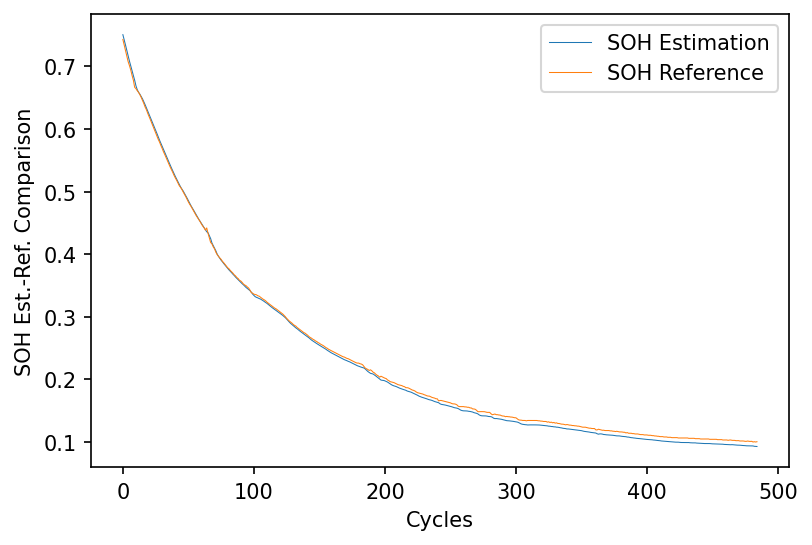

In [8]:
RMSE, MAE, Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True)

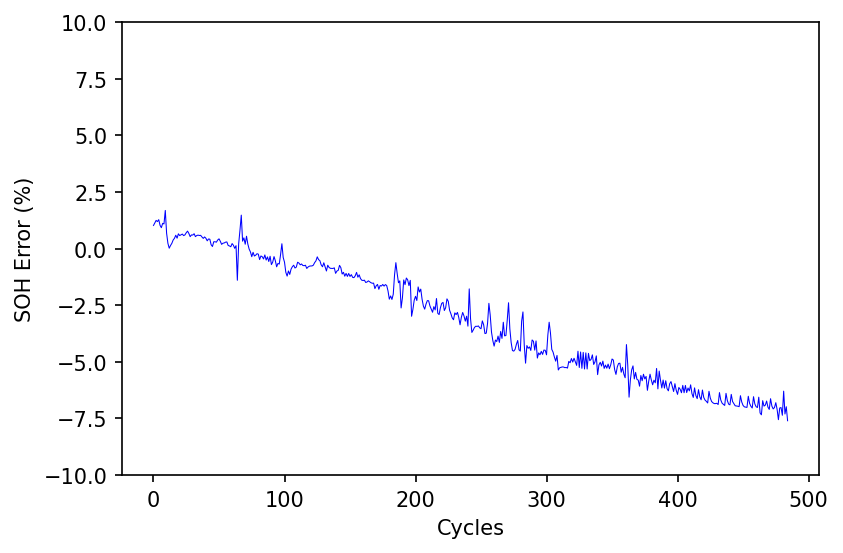

RMSE(0.005345), MAE(0.004891)


In [9]:
pl.figure(dpi=150)
line = pl.plot(Error_rate)
pl.ylim(-10, 10)
pl.ylabel('SOH Error (%)')
pl.xlabel('Cycles')
pl.setp(line, color='b', linewidth=0.5)
pl.savefig(f'{save_path}\\ErrRate-RMSE({RMSE:.4f})MAE({MAE:.4f}).png')
pl.show()
print(f'RMSE({RMSE:.6f}), MAE({MAE:.6f})')